# Exit contract optimization

## The following script simulates Examples 1 and 2 and displays the results.

In [1]:
#imports
from matplotlib import pyplot as plt
from scipy.integrate import odeint 
import numpy as np
from scipy.stats import norm
from tqdm.notebook import tqdm

## <ins> Example 1 <ins>
First, we set the diffusion parameters of $X$ defined by 
\begin{align*}
    X_t=x+\mu t + \sigma W_t, \quad t\geq0
\end{align*}

In [22]:
#diffusion parameters
mu_0=-0.1
def mu(x):
    return mu_0
sigma_0=0.5
def sigma(x):
    return sigma_0
r_0=0.01
def r(x): 
    return r_0
x_0=0

We define the solutions $\varphi$ and $\psi$ of the generator ODE:
\begin{align*}
    \frac{\sigma^2}{2}w''(x)+\mu w'(x)-rw(x)=0, \quad x\in\mathbb{R}
\end{align*}

In [23]:
c_1=-mu_0/sigma_0**2-np.sqrt((mu_0/sigma_0**2)**2+2*r_0/sigma_0**2)
c_2=-mu_0/sigma_0**2+np.sqrt((mu_0/sigma_0**2)**2+2*r_0/sigma_0**2)

def phi(x):
    return np.exp(c_1*x)
def psi(x):
    return np.exp(c_2*x)

Next, we set the parameter of the payoffs
\begin{align*}
    g_t(l)&=re^{-rt}\big(2\alpha_0 l+\alpha_1 X_t\big)\quad &&(t, l)\in[0,\infty)\times\mathbb{R},\\
    f_t(l)&=re^{-rt}\big(\beta_0 l + \beta_1  X_t\big)\quad &&(t, l)\in[0,\infty)\times\mathbb{R}.
\end{align*}
Now, we can define the signal
\begin{align*}
    \gamma(x)=\begin{cases}
        -\frac{\alpha_1+\beta_1}{2(\alpha_0+\beta_0)}(x+\frac{\mu}{r}-\frac{1}{c_1}), \quad\text{if } \alpha_1+\beta_1\geq0\\
        -\frac{\alpha_1+\beta_1}{2(\alpha_0+\beta_0)}(x+\frac{\mu}{r}-\frac{1}{c_2}),\quad\text{else.}
    \end{cases}
\end{align*}

In [24]:
#principle and agent reward structure
alpha_0=1
alpha_1=1
beta_0=1
beta_1=1

def alpha(x):
    return alpha_1*x

def beta(x):
    return beta_1*x


A=(alpha_1+beta_1)
B=mu_0*(alpha_1+beta_1)/r_0
def Gamma(x):
        return A*x+B
if A>=0:
    def gamma(x):
        return -(Gamma(x)-A/c_1)/(2*(alpha_0+beta_0))
    x_min = 1/c_1-mu_0/r_0-2*(alpha_0+beta_0)/(alpha_1+beta_1)
    x_max = 1/c_1-mu_0/r_0
else:
    def gamma(x):
        return -(Gamma(x)-A/c_2)/(2*(alpha_0+beta_0))
    x_max = 1/c_2-mu_0/r_0-2*(alpha_0+beta_0)/(alpha_1+beta_1)
    x_min = 1/c_2-mu_0/r_0

The following function lets us simulate a standard Brownian motion.

In [6]:
def simulate_W(T,dt,N):
    '''
    @input: steps - number of timessteps
            
    @output: W - realisation of a Brownian motion
    '''
    steps=round(T/dt)+1
    #simuliert die Inkremente der Brownschen Bewegung
    dW = norm.rvs(size = (steps,N), scale = np.sqrt(dt))
    dW[0]=np.zeros((N,))
    W = np.cumsum(dW, axis = 0)
    return W

We simulate a random path of the diffusion $X$ and calculate the corresponding optimal control
\begin{align*}
        L^*_t= 0 \vee \sup_{0\leq s < t} \gamma(X_t)  \wedge 1,  \quad t\geq0.
\end{align*}

In [7]:
def simulate_ex1(Tstart,Tend,dt,N,L_0,x_0,mu_0,sigma_0,r_0,gamma):
    
    steps=round((Tend-Tstart)/dt+1)
    W=simulate_W(Tend-Tstart,dt,N)
    times=np.linspace(0,Tend-Tstart,steps).reshape(steps,1)
    X=x_0+mu_0*times+sigma_0*W
    sup_gamma=np.maximum.accumulate(gamma(X))
    L=np.minimum(np.maximum(sup_gamma,np.full((steps,1),L_0)),np.full((steps,1),1))
    L[0]=L_0
    return W,X,L

We plot the results. Addionally, we highlight the threshholds $x_{max}\in\mathbb{R}$ and $x_{min}\in\mathbb{R}$. They satisfy
\begin{align*}
    \gamma(x)\in[0,1] \quad\text{for}\quad  x\in[x_{min},x_{max}].
\end{align*}

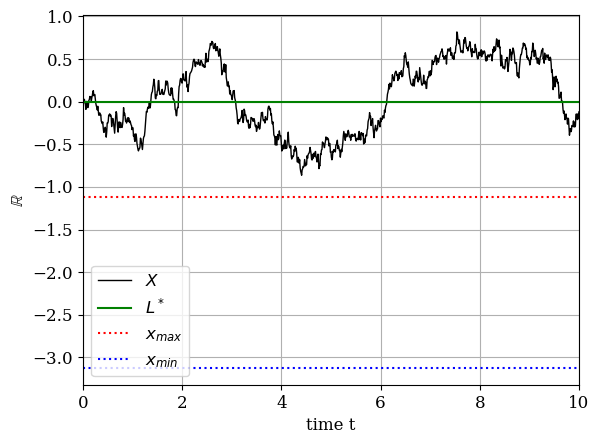

In [8]:
dt=0.01
T=10

W,X,L=simulate_ex1(0,T,dt,1,0,x_0,mu_0,sigma_0,r_0,gamma)
times=np.linspace(0,T,round((T)/dt+1))

plt.rc('font', **{'family': 'DeJavu Serif', 'serif': ['Computer Modern'], 'size':12})

plt.xlabel("time t")
plt.ylabel(r'$\mathbb{R}$')
if L[1]>0:
    plt.scatter(0, L[0],s=15, facecolors='g', edgecolors='g',clip_on=False,zorder=3)
    plt.scatter(dt, L[1],s=15, facecolors='white', edgecolors='g',clip_on=False,zorder=3)
    L=L.reshape((L.shape[0],))
    #print(L.shape,L.tolist())
    L_plot=[np.nan]*5+L.tolist()[5:]
else:
    L_plot=L
plt.plot(times, X, 'black', label=r'$X$',linewidth=1)
#plot as step function
plt.plot(times, L_plot, 'g', label=r'$L^*$')

plt.axhline(y = x_max, color = 'r', linestyle = 'dotted',label=r'$x_{max}$')
plt.axhline(y = x_min, color = 'b', linestyle = 'dotted',label=r'$x_{min}$')

plt.xlim(left=0,right=T)
plt.legend(loc='best')
plt.grid()
#only one of the two following
#plt.show()
plt.savefig("first",dpi=1000)

We may also display the relationship between $\sigma$ and the threshholds $x_{max}$ and $x_{min}$.

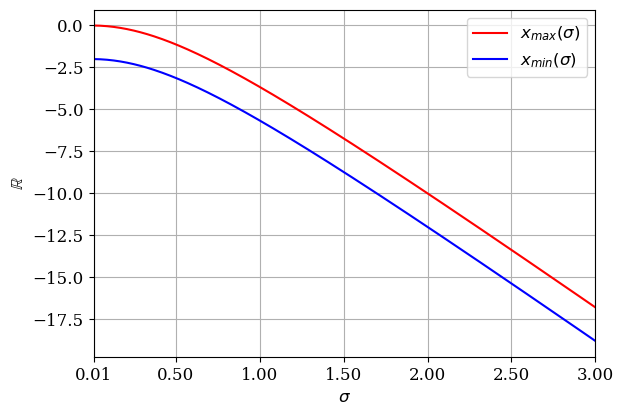

In [25]:
def c(s):
    return -mu_0/s**2-np.sqrt((mu_0/s**2)**2+2*r_0/s**2)
def xmax(c):
    return 1/c-mu_0/r_0
def xmin(c):
    return 1/c-mu_0/r_0-2*(alpha_0+beta_0)/(alpha_1+beta_1)

dx=0.01
J_min=dx
J_max=3
J=np.linspace(J_min,J_max,int((J_max-J_min)/dx+1))

plt.rc('font', **{'family': 'DeJavu Serif', 'serif': ['Computer Modern'], 'size':12})
plt.plot(J, xmax(c(J)), 'r', label=r'$x_{max}(\sigma)$')
plt.plot(J, xmin(c(J)), 'b', label=r'$x_{min}(\sigma)$')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\mathbb{R}$')
plt.gca().set_aspect(0.1)
plt.xlim(left=dx,right=3)
plt.xticks(ticks=[dx,0.5,1,1.5,2,2.5,3])
plt.legend(loc='best')
plt.grid()
plt.tight_layout()

plt.show()


After that, we use the sceme
\begin{align*}
    Z_T\approx \beta_1 \Bigg(e^{-r(T+H)}+\frac{1}{M}\sum_{m=1}^M\Bigg(\sum_{i=0}^{n-1} re^{-rt_i} L^m_{t_i}(t_{i+1}-t_i)\Bigg)\Bigg)+\mathbb{E}_T\Bigg[\int_T^\infty re^{-rt}\beta_1X_t  dt\Bigg],\quad T\geq0,
\end{align*}

to approximate the corresponding exit contract via Monte-Carlo.

In [10]:
N=100
Tmax=20

def approx_contract_ex1(T,Tmax,dt,N,x_0,mu_0,sigma_0,r_0,gamma):
    Y=[]
    delta=1
    times=np.linspace(0,T,round((T)/dt+1))
    for (step,t) in enumerate(tqdm(times)):
        if step%delta==0:
            steps_to_Tmax=round((Tmax)/dt+1)
            times_to_Tmax=np.linspace(t,Tmax+t,steps_to_Tmax)
            Lm=simulate_ex1(t,Tmax+t,dt,N,L[step],X[step],mu_0,sigma_0,r_0,gamma)[2]
            L_mean=1/N*np.sum(Lm,axis=1)
            integral=np.sum(r_0*np.exp(-r_0*times_to_Tmax)*L_mean*dt,axis=0)+L_mean[-1]*np.exp(-r_0*(t+Tmax))

            Y.append(beta_0*integral+beta_1*np.exp(-r_0*t)*(x_0+mu_0*t+mu_0/r_0+sigma_0*W[step]))
        else:
            Y.append(Y[-1])
    return np.array(Y)

Y=approx_contract_ex1(T,Tmax,dt,N,x_0,mu_0,sigma_0,r_0,gamma)

  0%|          | 0/1001 [00:00<?, ?it/s]

The following plots the results

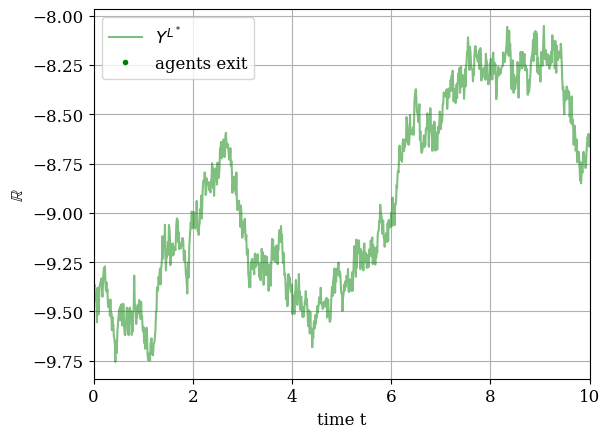

In [11]:
plt.plot(times, Y, 'g', label=r'$Y^{L^*}$',alpha=0.5)
t=times.reshape(times.shape[0],1)


#plots the points where agents exit
L=np.array(L.reshape((L.shape[0],)))
L_mask=np.array([L[i]==L[i+1] for i in range(len(L)-1)]+[True])
Y=Y.reshape((Y.shape[0],))
Y_masked=np.ma.masked_where(L_mask,Y)

plt.ylabel(r'$\mathbb{R}$')
plt.xlabel("time t")
plt.plot(times, Y_masked, 'g', label='agents exit',marker="o",linestyle="None",markersize=3)
plt.legend(loc='best')
plt.xlim(left=0,right=T)
plt.grid()
plt.show()

## <ins> Example 2 <ins>
   Let us transition to Example 2. We again set the diffusion parameters for the geometric brownian motion $X$ given by
\begin{align*}
    dX_t = \mu X_td t+ \sigma X_t d W_t,
\end{align*}

In [12]:
mu=0.5
sigma=0.3
x_0=0.1
r=0.111

We define the solutions $\psi$ and $\varphi$ of the respectiv generator ODE: 
\begin{align*}
    \frac{\sigma^2x^2}{2}w''(x)+\mu xw'(x)-rw(x)=0, \quad x\in(0,\infty),
\end{align*}

In [13]:
c_1=-(mu/sigma**2-1/2)-np.sqrt((mu/sigma**2-1/2)**2+2*r/sigma**2)
c_2=-(mu/sigma**2-1/2)+np.sqrt((mu/sigma**2-1/2)**2+2*r/sigma**2)


def phi(x):
    return np.power(x,c_1)
def psi(x):
    return np.power(x,c_2)

In this example we have the payoffs
\begin{align*}
    g_t(l)&=re^{-rt}\big(2\alpha_0 l- X_t^{\alpha_1}\big), \quad &&(t, l)\in[0,\infty)\times\mathbb{R},\\
    f_t(l)&=re^{-rt}\big(\beta_0 l -   X_t^{\beta_1}\big),\quad  &&(t, l)\in[0,\infty)\times\mathbb{R}.
\end{align*}
The resulting singal $\gamma$ is
\begin{align*}
    \gamma(x)=\tilde{\Gamma}(x)-\tilde{\Gamma}'(x)\frac{x}{c_2}=\frac{A(1+\frac{\alpha_1}{c_2})x^{\alpha_1}+B(1+\frac{\beta_1}{c_2})x^{\beta_1}}{2(\alpha_0+\beta_0)}, \quad x\in(0,\infty),
\end{align*}
where $A:=\frac{r}{r-\mu\alpha_1-\frac{\sigma^2\alpha_1(\alpha_1-1)}{2}}$ and $B:=\frac{r}{r-\mu\beta_1-\frac{\sigma^2\beta_1(\beta_1-1)}{2}}$.

In [14]:
#principle and agent reward structure
alpha_0=5
alpha_1=0.1
beta_0=5
beta_1=0.1

def alpha(x):
    return alpha_1*x

def beta(x):
    return beta_1*x
A=r/(r-mu*alpha_1-sigma**2*alpha_1*(alpha_1-1)/2)
B=r/(r-mu*beta_1-sigma**2*beta_1*(beta_1-1)/2)
if A<=0 or B<=0:
    print("r must be strictly greater than",max(mu*alpha_1+sigma**2*alpha_1*(alpha_1-1)/2,
                                                mu*beta_1+sigma**2*beta_1*(beta_1-1)/2)) 
else:
    def gamma(x):
        return (A*(1+alpha_1/c_2)*np.power(x,alpha_1)+B*(1+beta_1/c_2)*np.power(x,beta_1))/(2*(alpha_0+beta_0))

We simulate the geometric brownian motion $X$ and calculate the optimal control 
\begin{align*}
        L^*_t= 0 \vee \sup_{0\leq s < t} \gamma(X_t)  \wedge 1,  \quad t\geq0.
\end{align*}

In [15]:
def simulate_ex2(Tstart,Tend,dt,N,L_0,x_0,mu_0,sigma_0,r_0,gamma):
    
    steps=round((Tend-Tstart)/dt+1)
    
    W=simulate_W(Tend-Tstart,dt,N)
    times=np.linspace(0,Tend-Tstart,steps).reshape(steps,1)
    X=x_0*np.exp((mu-sigma**2/2)*times+sigma*W)
    sup_gamma=np.maximum.accumulate(gamma(X))
    L=np.minimum(np.maximum(sup_gamma,np.full((steps,1),L_0)),np.full((steps,1),1))
    L[0]=L_0
    return W,X,L
W,X,L=simulate_ex2(0,T,dt,1,0,x_0,mu,sigma,r,gamma)

Then we plot the results.

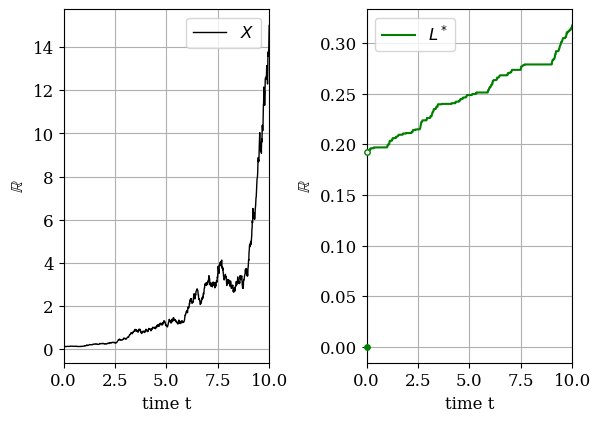

In [16]:
times=np.linspace(0,T,round((T)/dt+1))

fig, axs=plt.subplots(1, 2)
plt.rc('font', **{'family': 'DeJavu Serif', 'serif': ['Computer Modern'], 'size':12})

#plots the potential discontinuity in 0
if L[1]>0:
    axs[1].scatter(0, L[0],s=15, facecolors='g', edgecolors='g',clip_on=False,zorder=3)
    axs[1].scatter(dt, L[1],s=15, facecolors='white', edgecolors='g',clip_on=False,zorder=3)
    L=L.reshape((L.shape[0],))
    #print(L.shape,L.tolist())
    L_plot=[np.nan]*5+L.tolist()[5:]
else:
    L_plot=L
    
axs[0].plot(times, X, 'black', label=r'$X$',linewidth=1)
axs[1].plot(times, L_plot, 'g', label=r'$L^*$')
fig.tight_layout(pad=3)
axs[0].set_xlabel("time t")
axs[1].set_xlabel("time t")
axs[0].set_ylabel(r'$\mathbb{R}$')
axs[1].set_ylabel(r'$\mathbb{R}$')
axs[0].set_xlim(left=0,right=T)
axs[1].set_xlim(left=0,right=T)
axs[0].legend(loc='best')
axs[1].legend(loc='best')
axs[0].grid()
axs[1].grid()
plt.show()